# 0 load packages

In [2]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt, norm 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg

Define functions

In [3]:
def calc_one_zero_error(T,Estimate, ratio = True):
    d = T.shape[0]
    T[np.abs(T)<1e-7] = 0.0
    Estimate[np.abs(Estimate)<1e-7] = 0.0
    error = np.sum(~(np.sign(T[np.triu_indices(T.shape[0], k = 1)]) == np.sign(Estimate[np.triu_indices(Estimate.shape[0], k = 1)])))
    if ratio:
        error = error/float(d*(d-1)/2)
    return error



def plot_edges(prec_list, theta, edges):

    # red grey green blue
    colors_light = ['black', '#D0CDC9', '#6EA96E', '#D6F6F6']
    colors_dark = ['#CC1100', '#8B7500','#00688B', '#00688B']

    fig, ax = plt.subplots(1,len(edges), figsize = (5*len(edges),5))

    plot_once_edge = True
    

    d = theta.shape[1]


    
    for cnt2, e in enumerate(edges):

        if len(edges) == 1:
            if plot_once_edge:
                ax.plot(prec_list[:,e[0],e[1]], label = "True", color = colors_light[0])
            
            ax.set_title(f"Edge ({e[0]+1}, {e[1]+1})")
                
            ax.plot(theta[:,e[0],e[1]], linestyle = '--', color = colors_dark[0])
            
            ax.legend(bbox_to_anchor = (1,1))
            ax.set_xlabel("Time")
            ax.set_ylabel("Edge weight")
        else:
            if plot_once_edge:
                ax[cnt2].plot(prec_list[:,e[0],e[1]], label = "True", color = colors_light[0])
            
            ax[cnt2].set_title(f"Edge ({e[0]+1}, {e[1]+1})")

            ax[cnt2].plot(theta[:,e[0],e[1]])
                
            if cnt2 == len(edges)-1:
                ax[cnt2].legend(bbox_to_anchor = (1,1))
            ax[cnt2].set_xlabel("Time")
            ax[cnt2].set_ylabel("Edge weight")

    plot_once_edge = False

Introduction

Temporal penalties:
* element-wise
*
*
*
*

Distributions
* gaussian
* t

In [13]:

from sklearn.datasets import make_sparse_spd_matrix
prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.2, largest_coef=0.8, norm_diag = True,random_state=42)

print(np.round(prec_0,2))
prec_1 = prec_0.copy()
prec_1[1,4] = 0
prec_1[4,1] = 0
print(np.round(prec_1,2))








[[ 1.    0.    0.13  0.   -0.55]
 [ 0.    1.    0.    0.09 -0.31]
 [ 0.13  0.    1.    0.   -0.5 ]
 [ 0.    0.09  0.    1.    0.  ]
 [-0.55 -0.31 -0.5   0.    1.  ]]
[[ 1.    0.    0.13  0.   -0.55]
 [ 0.    1.    0.    0.09  0.  ]
 [ 0.13  0.    1.    0.   -0.5 ]
 [ 0.    0.09  0.    1.    0.  ]
 [-0.55  0.   -0.5   0.    1.  ]]


In [14]:
prec_0

array([[ 1.        ,  0.        ,  0.13373616,  0.        , -0.54739138],
       [ 0.        ,  1.        ,  0.        ,  0.09171019, -0.31028148],
       [ 0.13373616,  0.        ,  1.        ,  0.        , -0.5042745 ],
       [ 0.        ,  0.09171019,  0.        ,  1.        ,  0.        ],
       [-0.54739138, -0.31028148, -0.5042745 ,  0.        ,  1.        ]])

In [15]:
prec_1

array([[ 1.        ,  0.        ,  0.13373616,  0.        , -0.54739138],
       [ 0.        ,  1.        ,  0.        ,  0.09171019,  0.        ],
       [ 0.13373616,  0.        ,  1.        ,  0.        , -0.5042745 ],
       [ 0.        ,  0.09171019,  0.        ,  1.        ,  0.        ],
       [-0.54739138,  0.        , -0.5042745 ,  0.        ,  1.        ]])

# Gaussian Data

In [16]:
n = 1000
X1 = np.random.multivariate_normal(mean = np.zeros(prec_0.shape[0]), cov = np.linalg.inv(prec_0),size=(n) )
X2 = np.random.multivariate_normal(mean = np.zeros(prec_1.shape[0]), cov = np.linalg.inv(prec_1),size=(n) )
X = np.vstack((X1,X2))

Fit a Gaussian model

In [35]:
obs_per_graph = 100
gaussian_model = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 10000, lamda = obs_per_graph*0.5, kappa = obs_per_graph*0.01, tol = 1e-8)
gaussian_model.fit(X,'element-wise', time_index=range(X.shape[0]))

Error 1.01E-8:   2%|▏         | 241/10000 [00:00<00:27, 355.88it/s]


plot edges

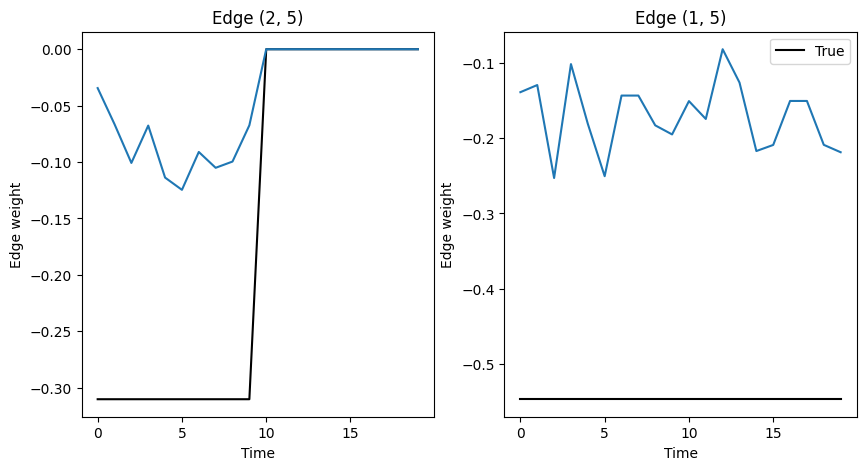

In [36]:
prec_list = np.array([prec_0]*10 + [prec_1]*10)

plot_edges(prec_list, gaussian_model.theta, [(1,4), (0,4)])

# Student T data

In [21]:
n = 1000
X1 = mvt.rvs(shape = np.linalg.inv(prec_0),  df = 4, size = n)
X2 = mvt.rvs(shape = np.linalg.inv(prec_1),  df = 4, size = n)
X = np.vstack((X1,X2))


In [30]:
2*n/obs_per_graph

20.0

In [27]:
obs_per_graph = 100
dg_opt1 = dg.dygl_parallel(obs_per_graph = obs_per_graph, max_iter = 1000, lamda = obs_per_graph*0.05, kappa = obs_per_graph*0.5, tol = 1e-10)
dg_opt1.fit(X, nr_workers=7, temporal_penalty="element-wise", lik_type="t", nr_em_itr = 1, time_index=range(X.shape[0]), nu = 4)


Error 6.84E-5: 100%|██████████| 1000/1000 [00:07<00:00, 142.06it/s]


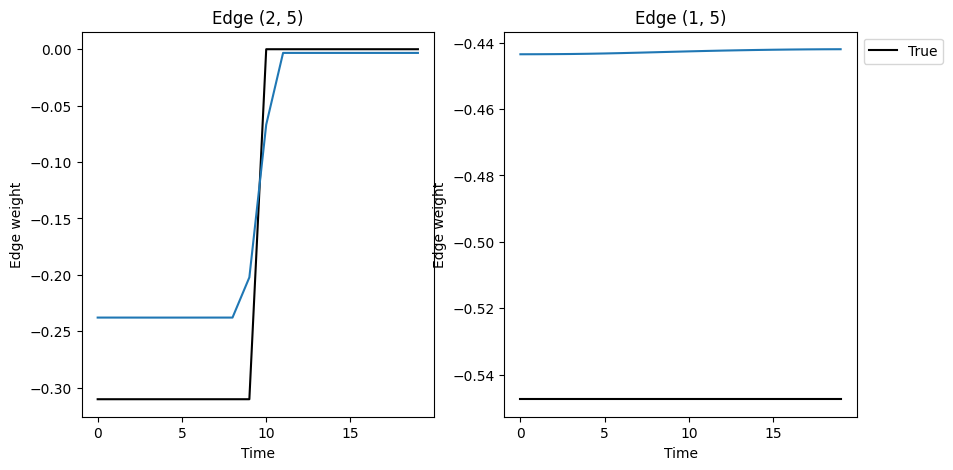

In [28]:
prec_list = np.array([prec_0]*10 + [prec_1]*10)

plot_edges(prec_list, dg_opt1.theta, [(1,4), (0,4)])